# Stock Prediction Using Deep Learning Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU

In [2]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error (Loss)')
  plt.ylim([0,0.005])
  plt.legend(loc='upper right')
  plt.grid(True)

# A. Data Exploration

Karena kita akan menggunakan `Close` sebagai target variable, maka kita akan memisahkannya ke dalam variabel baru, yaitu `AMD_Close`. Disini saya juga me-reshape data dari `AMD_Close` agar bisa diproses lebih lanjut

In [3]:
def data_preprocessing(dataset):
  data_close = dataset.Close.values
  data_close = data_close.reshape(-1,1)

  scaler = MinMaxScaler(feature_range= (0,1))
  data_close_scaled = scaler.fit_transform(data_close)

  return data_close_scaled

Disini saya melakukan scaling dengan MinMaxScaler dimana MinMax scalling ini sangat berguna untuk input features yang mempunyai different scales. Dengan melakukan scalling pada data, kita bisa memastikan weight dan gradient dari model akan terupdate secara beragam ke semua features, dimana akan menghasilkan hasil training yang stabil dan efisien.

Reference:
"Understanding the Difficulty of Training Deep Feedforward Neural Networks"

http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

In [4]:
def tumbling_window(dataset_scaled, window_size, inputs, outputs):

  for i in range(0, len(dataset_scaled) - window_size + 1, window_size):
    window = dataset_scaled[i:i + window_size]
    labels = dataset_scaled[i + window_size]
    inputs.append(window)
    outputs.append(labels)

Disini saya akan melakukan pemisahan data time series dengan window size = 5 [dari hari senin s.d jumat] dan horizon = 1 [hari senin saja], maka untuk bagian window ini saya menggunakan **Tumbling Window** dimana akan memisah time series data menjadi segmen-segmen yang saling terpisah.

In [5]:
def window_preview(inputs, outputs, ranges):
  for i in range(ranges):
    print(f"\nWindow: \n{inputs[i]} \n-> Horizon: {outputs[i]}")

In [6]:
def data_splitting(inputs, outputs):
  from sklearn.model_selection import train_test_split

  inputs = np.array(inputs)
  outputs = np.array(outputs)

  X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, shuffle=False)
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

  return X_train, X_test, X_val, y_train, y_test, y_val

## AMD

In [7]:
AMD_data = pd.read_csv('dataset/AMD.csv')

In [8]:
AMD_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10098 entries, 0 to 10097
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10098 non-null  object 
 1   Open       10098 non-null  float64
 2   High       10098 non-null  float64
 3   Low        10098 non-null  float64
 4   Close      10098 non-null  float64
 5   Adj Close  10098 non-null  float64
 6   Volume     10098 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 552.4+ KB


In [9]:
AMD_data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.0,3.302083,3.125000,3.145833,3.145833,219600
1,1980-03-18,0.0,3.125000,2.937500,3.031250,3.031250,727200
2,1980-03-19,0.0,3.083333,3.020833,3.041667,3.041667,295200
3,1980-03-20,0.0,3.062500,3.010417,3.010417,3.010417,159600
4,1980-03-21,0.0,3.020833,2.906250,2.916667,2.916667,130800


In [10]:
AMD_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
10093,2020-03-26,45.779999,47.500000,45.400002,47.500000,47.500000,73680200
10094,2020-03-27,46.320000,47.980000,45.900002,46.580002,46.580002,74599200
10095,2020-03-30,47.240002,48.459999,46.660000,47.860001,47.860001,68486600
10096,2020-03-31,47.930000,48.529999,45.160000,45.480000,45.480000,83483700
10097,2020-04-01,44.180000,46.849998,43.160000,43.660000,43.660000,91895000


Dalam dataset ini terdapat 5 variabel dengan tipe data *numeric* dan juga 1 variabel dengan tipe data *datetime*. Ada 1 hal yang janggal dimana kolom `Date` tidak terdeteksi sebagai *datetime* melainkan *object*. Maka dari itu, saya mengganti tipe data dari kolom `date` menjadi tipe data *datetime*

In [11]:
AMD_data.Date = pd.to_datetime(AMD_data.Date.str.strip(), format='%Y-%m-%d')

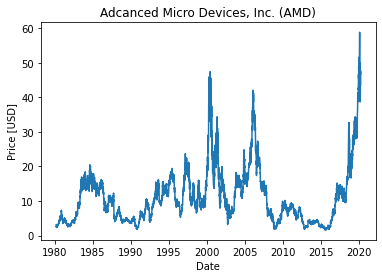

In [12]:
plt.plot(AMD_data.Date, AMD_data.Close)
plt.xlabel("Date")
plt.ylabel("Price [USD]")
plt.title("Adcanced Micro Devices, Inc. (AMD)")
plt.show()

In [13]:
AMD_close_scaled = data_preprocessing(AMD_data)

In [14]:
AMD_close_scaled

array([[0.02663815],
       [0.02463774],
       [0.0248196 ],
       ...,
       [0.80726256],
       [0.76571226],
       [0.73393853]])

In [15]:
WINDOW_SIZE = 5
HORIZON = 1

AMD_inputs = []
AMD_outputs = []

tumbling_window(AMD_close_scaled, WINDOW_SIZE, AMD_inputs, AMD_outputs)

In [16]:
print(len(AMD_inputs))
print(len(AMD_outputs))

2019
2019


In [17]:
window_preview(inputs=AMD_inputs, outputs = AMD_outputs, ranges = 5)


Window: 
[[0.02663815]
 [0.02463774]
 [0.0248196 ]
 [0.02427403]
 [0.02263734]] 
-> Horizon: [0.01827281]

Window: 
[[0.01827281]
 [0.01718168]
 [0.01445385]
 [0.01318087]
 [0.01609055]] 
-> Horizon: [0.01609055]

Window: 
[[0.01609055]
 [0.0195458 ]
 [0.01754539]
 [0.01772725]
 [0.01609055]] 
-> Horizon: [0.01699982]

Window: 
[[0.01699982]
 [0.01827281]
 [0.0195458 ]
 [0.01772725]
 [0.01645426]] 
-> Horizon: [0.01645426]

Window: 
[[0.01645426]
 [0.01281716]
 [0.01409014]
 [0.01227159]
 [0.01172603]] 
-> Horizon: [0.01645426]


In [18]:
AMDx_train, AMDx_test, AMDx_val, AMDy_train, AMDy_test, AMDy_val = data_splitting(AMD_inputs, AMD_outputs)

In [19]:
AMDx_train

array([[[0.02663815],
        [0.02463774],
        [0.0248196 ],
        [0.02427403],
        [0.02263734]],

       [[0.01827281],
        [0.01718168],
        [0.01445385],
        [0.01318087],
        [0.01609055]],

       [[0.01609055],
        [0.0195458 ],
        [0.01754539],
        [0.01772725],
        [0.01609055]],

       ...,

       [[0.10212988],
        [0.10300279],
        [0.10003491],
        [0.10282821],
        [0.10195531]],

       [[0.09514665],
        [0.09217877],
        [0.09689246],
        [0.10212988],
        [0.10405028]],

       [[0.10265363],
        [0.10719274],
        [0.10719274],
        [0.1157472 ],
        [0.1148743 ]]])

In [20]:
AMDy_train

array([[0.01827281],
       [0.01609055],
       [0.01699982],
       ...,
       [0.09514665],
       [0.10265363],
       [0.11452514]])

In [21]:
print("Train set size:", len(AMDx_train))
print("Validation set size:", len(AMDx_test))
print("Test set size:", len(AMDx_val))

Train set size: 1615
Validation set size: 202
Test set size: 202


In [22]:
AMDx_train = np.reshape(AMDx_train, (AMDx_train.shape[0],AMDx_train.shape[1],1 ))
AMDx_test = np.reshape(AMDx_test, (AMDx_test.shape[0],AMDx_test.shape[1],1 ))
AMDx_val = np.reshape(AMDx_val, (AMDx_val.shape[0],AMDx_val.shape[1],1 ))
AMDx_train.shape

(1615, 5, 1)

In [23]:
AMDy_train.shape

(1615, 1)

## AAPL

In [24]:
AAPL_data = pd.read_csv('dataset/AAPL.csv')

In [25]:
AAPL_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9909 entries, 0 to 9908
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9909 non-null   object 
 1   Open       9909 non-null   float64
 2   High       9909 non-null   float64
 3   Low        9909 non-null   float64
 4   Close      9909 non-null   float64
 5   Adj Close  9909 non-null   float64
 6   Volume     9909 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 542.0+ KB


In [26]:
AAPL_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


In [27]:
AAPL_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
9904,2020-03-26,246.520004,258.679993,246.360001,258.440002,258.440002,63021800
9905,2020-03-27,252.750000,255.869995,247.050003,247.740005,247.740005,51054200
9906,2020-03-30,250.740005,255.520004,249.399994,254.809998,254.809998,41994100
9907,2020-03-31,255.600006,262.489990,252.000000,254.289993,254.289993,49250500
9908,2020-04-01,246.500000,248.720001,239.130005,240.910004,240.910004,43956200


In [28]:
AAPL_data.Date = pd.to_datetime(AAPL_data.Date.str.strip(), format='%Y-%m-%d')

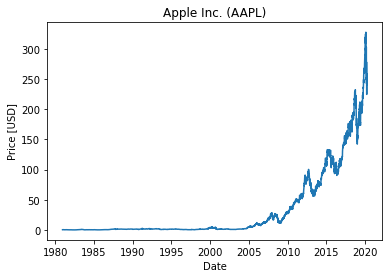

In [29]:
plt.plot(AAPL_data.Date, AAPL_data.Close)
plt.xlabel("Date")
plt.ylabel("Price [USD]")
plt.title("Apple Inc. (AAPL)")
plt.show()

In [30]:
AAPL_close_scaled = data_preprocessing(AAPL_data)
AAPL_close_scaled

array([[9.69299159e-04],
       [8.87386505e-04],
       [7.78169755e-04],
       ...,
       [7.78626234e-01],
       [7.77036025e-01],
       [7.36119074e-01]])

In [31]:
AAPL_inputs = []
AAPL_outputs = []

tumbling_window(AAPL_close_scaled, WINDOW_SIZE, AAPL_inputs, AAPL_outputs)

In [32]:
window_preview(inputs=AAPL_inputs, outputs = AAPL_outputs, ranges = 5)


Window: 
[[0.0009693 ]
 [0.00088739]
 [0.00077817]
 [0.0008123 ]
 [0.00085326]] 
-> Horizon: [0.00094199]

Window: 
[[0.00094199]
 [0.00101708]
 [0.00108534]
 [0.00117408]
 [0.00133791]] 
-> Horizon: [0.00136521]

Window: 
[[0.00136521]
 [0.00131743]
 [0.00126282]
 [0.0012833 ]
 [0.00124234]] 
-> Horizon: [0.00116043]

Window: 
[[0.00116043]
 [0.00108534]
 [0.00105121]
 [0.00113995]
 [0.0011263 ]] 
-> Horizon: [0.00106486]

Window: 
[[0.00106486]
 [0.00107169]
 [0.00110582]
 [0.00109217]
 [0.00119456]] 
-> Horizon: [0.00113995]


In [33]:
AAPLx_train, AAPLx_test, AAPLx_val, AAPLy_train, AAPLy_test, AAPLy_val = data_splitting(AAPL_inputs, AAPL_outputs)

In [34]:
AAPLx_train = np.reshape(AAPLx_train, (AAPLx_train.shape[0],AAPLx_train.shape[1],1 ))
AAPLx_test = np.reshape(AAPLx_test, (AAPLx_test.shape[0],AAPLx_test.shape[1],1 ))
AAPLx_val = np.reshape(AAPLx_val, (AAPLx_val.shape[0],AAPLx_val.shape[1],1 ))
AAPLx_train.shape

(1584, 5, 1)

In [35]:
AAPLy_train.shape

(1584, 1)

# B. Baseline Architecture



In [36]:
def baseline_model():

  tf.keras.backend.clear_session()
  model = Sequential()
  model.add(LSTM(units=50, activation='relu', input_shape=(WINDOW_SIZE, 1)))
  model.add(Dense(units=1, activation='relu'))

  model.compile(optimizer='adam', loss='mean_squared_error')

  return model

In [37]:
model_baseline = baseline_model()
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [38]:
def history_model(model, X_train, y_train, X_val, y_val):
  history = model.fit(X_train, y_train, epochs=10, validation_data = (X_val, y_val), batch_size = 1)
  return history

## AMD

In [39]:
AMD_baseline_history = history_model(model_baseline, AMDx_train, AMDy_train, AMDx_val, AMDy_val)

Epoch 1/10


1615/1615 [==============================] - 5s 2ms/step - loss: 0.0010 - val_loss: 1.3646e-05
Epoch 2/10
1615/1615 [==============================] - 4s 2ms/step - loss: 3.0026e-04 - val_loss: 1.0059e-05
Epoch 3/10
1615/1615 [==============================] - 4s 2ms/step - loss: 2.2420e-04 - val_loss: 1.6765e-04
Epoch 4/10
1615/1615 [==============================] - 3s 2ms/step - loss: 2.3569e-04 - val_loss: 4.6330e-05
Epoch 5/10
1615/1615 [==============================] - 4s 2ms/step - loss: 1.8028e-04 - val_loss: 1.2726e-04
Epoch 6/10
1615/1615 [==============================] - 4s 2ms/step - loss: 1.9535e-04 - val_loss: 2.8170e-05
Epoch 7/10
1615/1615 [==============================] - 3s 2ms/step - loss: 1.7860e-04 - val_loss: 3.3485e-05
Epoch 8/10
1615/1615 [==============================] - 3s 2ms/step - loss: 1.6436e-04 - val_loss: 2.4360e-05
Epoch 9/10
1615/1615 [==============================] - 4s 2ms/step - loss: 1.4622e-04 - val_loss: 8.1462e-06
Epoch 10/10
1615/1615 [==

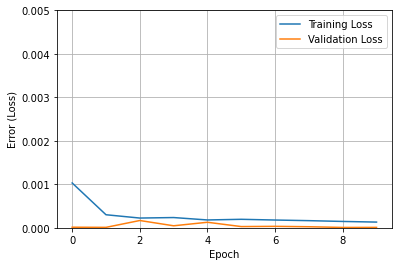

In [40]:
plot_loss(AMD_baseline_history)

## AAPL

In [41]:
AAPL_baseline_history = history_model(model_baseline, AAPLx_train, AAPLy_train, AAPLx_val, AAPLy_val)

Epoch 1/10
1584/1584 [==============================] - 3s 2ms/step - loss: 1.9020e-06 - val_loss: 3.2264e-05
Epoch 2/10
1584/1584 [==============================] - 3s 2ms/step - loss: 1.9209e-06 - val_loss: 5.1533e-05
Epoch 3/10
1584/1584 [==============================] - 3s 2ms/step - loss: 6.0573e-06 - val_loss: 1.2812e-04
Epoch 4/10
1584/1584 [==============================] - 3s 2ms/step - loss: 4.2256e-06 - val_loss: 3.8109e-05
Epoch 5/10
1584/1584 [==============================] - 3s 2ms/step - loss: 3.9520e-06 - val_loss: 8.1854e-05
Epoch 6/10
1584/1584 [==============================] - 3s 2ms/step - loss: 7.2714e-06 - val_loss: 5.0403e-05
Epoch 7/10
1584/1584 [==============================] - 3s 2ms/step - loss: 4.0268e-06 - val_loss: 4.2153e-05
Epoch 8/10
1584/1584 [==============================] - 3s 2ms/step - loss: 5.5974e-06 - val_loss: 2.2902e-05
Epoch 9/10
1584/1584 [==============================] - 3s 2ms/step - loss: 8.1745e-06 - val_loss: 4.0324e-05
Epoch 10/1

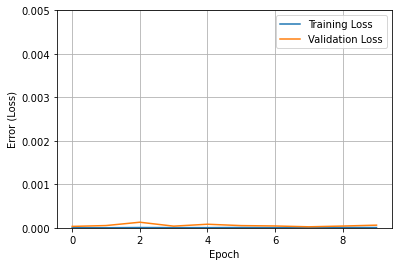

In [42]:
plot_loss(AAPL_baseline_history)

# C. Modified Architecture

## Modified Architecture 1

Untuk Modified Architecture yang pertama, disini saya mencoba untuk mengurangi layer dari LSTM yang tadinya 50 menjadi 10. Saya melakukan pengurangan tersebut karena based on data yang ada itu relatif sedikit dimana ketika menggunakan model yang cukup kompleks akan menghasilkan hasil yang kurang optimal [1].

References:

[1]. "Reducing the Complexity of Two-Dimensional LSTMs" by Zhang and Woodland (2018) https://www.isca-speech.org/archive_v0/Interspeech_2017/pdfs/1164.PDF

In [43]:
from tensorflow.keras.layers import Dropout

In [44]:
def modified_model1():

  tf.keras.backend.clear_session()
  model = Sequential()
  model.add(LSTM(units=10, activation='relu', input_shape=(WINDOW_SIZE, 1)))
  model.add(Dense(units=1, activation='relu'))

  model.compile(optimizer='adam', loss='mean_squared_error')

  return model

In [45]:
model_modified1 = modified_model1()
model_modified1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [46]:
AMD_modified_history1 = history_model(model_modified1, AMDx_train, AMDy_train, AMDx_val, AMDy_val)

Epoch 1/10


1615/1615 [==============================] - 4s 2ms/step - loss: 0.0440 - val_loss: 0.0014
Epoch 2/10
1615/1615 [==============================] - 3s 2ms/step - loss: 0.0440 - val_loss: 0.0014
Epoch 3/10
1615/1615 [==============================] - 3s 2ms/step - loss: 0.0440 - val_loss: 0.0014
Epoch 4/10
1615/1615 [==============================] - 3s 2ms/step - loss: 0.0440 - val_loss: 0.0014
Epoch 5/10
1615/1615 [==============================] - 3s 2ms/step - loss: 0.0440 - val_loss: 0.0014
Epoch 6/10
1615/1615 [==============================] - 3s 2ms/step - loss: 0.0440 - val_loss: 0.0014
Epoch 7/10
1615/1615 [==============================] - 3s 2ms/step - loss: 0.0440 - val_loss: 0.0014
Epoch 8/10
1615/1615 [==============================] - 3s 2ms/step - loss: 0.0440 - val_loss: 0.0014
Epoch 9/10
1615/1615 [==============================] - 3s 2ms/step - loss: 0.0440 - val_loss: 0.0014
Epoch 10/10
1615/1615 [==============================] - 3s 2ms/step - loss: 0.0440 - val_los

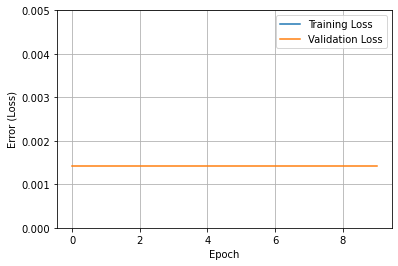

In [47]:
plot_loss(AMD_modified_history1)

## Modfied Architecture - 2

Untuk modified architecture kedua, disini saya mencoba untuk menggunakan BiLSTM. Dalam paper yang saya researh, BiLSTM modelling memberikan hasil prediksi yang lebih akurat dalam forecasting time-series data dibandingkan LSTM [1]. Maka dari itu, saya mencoba untuk menggunakan BiLSTM.

References:

[1]. S. Siami-Namini, N. Tavakoli and A. S. Namin, "The Performance of LSTM and BiLSTM in Forecasting Time Series," 2019 IEEE International Conference on Big Data (Big Data), Los Angeles, CA, USA, 2019, pp. 3285-3292, doi: 10.1109/BigData47090.2019.9005997.

In [48]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Bidirectional

def modified_model2():
  tf.keras.backend.clear_session()
  model = Sequential()
  model.add(Bidirectional(LSTM(units=10, activation='relu', input_shape=(WINDOW_SIZE, 1))))
  model.add(Dense(1, activation='relu'))

  model.compile(optimizer='adam', loss='mean_squared_error')

  sample_input = np.zeros((1, WINDOW_SIZE, 1))
  model.predict(sample_input)

  return model


BiLSTM, atau Bidirectional Long Short-Term Memory, adalah pengembangan dari model LSTM tradisional yang memiliki kemampuan untuk memproses informasi dari kedua arah, yaitu maju (forward) dan mundur (backward). Dengan adanya komponen rekursi maju dan mundur, BiLSTM dapat menangkap dan memanfaatkan konteks sebelum dan sesudah suatu titik waktu dalam urutan data. Hal ini memungkinkan BiLSTM untuk mengenali pola temporal yang kompleks dan menghasilkan prediksi yang lebih akurat.

In [49]:
model_modified2 = modified_model2()
model_modified2.summary()

1/1 [==============================] - 1s 731ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 20)               960       
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [50]:
AMD_modified_history2 = history_model(model_modified2, AMDx_train, AMDy_train, AMDx_val, AMDy_val)

Epoch 1/10
1615/1615 [==============================] - 6s 3ms/step - loss: 0.0021 - val_loss: 5.6977e-05
Epoch 2/10
1615/1615 [==============================] - 4s 2ms/step - loss: 2.3003e-04 - val_loss: 1.1317e-05
Epoch 3/10
1615/1615 [==============================] - 4s 2ms/step - loss: 2.2461e-04 - val_loss: 8.8624e-05
Epoch 4/10
1615/1615 [==============================] - 4s 2ms/step - loss: 2.1888e-04 - val_loss: 2.8412e-05
Epoch 5/10
1615/1615 [==============================] - 4s 2ms/step - loss: 2.2522e-04 - val_loss: 2.8953e-05
Epoch 6/10
1615/1615 [==============================] - 4s 2ms/step - loss: 2.1430e-04 - val_loss: 3.5248e-05
Epoch 7/10
1615/1615 [==============================] - 4s 2ms/step - loss: 2.0082e-04 - val_loss: 1.0081e-05
Epoch 8/10
1615/1615 [==============================] - 4s 2ms/step - loss: 2.0468e-04 - val_loss: 8.5025e-06
Epoch 9/10
1615/1615 [==============================] - 4s 2ms/step - loss: 1.8613e-04 - val_loss: 1.3516e-05
Epoch 10/10
16

## Modified Architecture - 3

Untuk modified architecture ke 3, disini saya mencoba untuk mengganti LSTM menjadi GRU. Dari research antara LSTM dan GRU untuk Stock Price Prediction, metode GRU dan Long Short-Term Memory (LSTM) memiliki performa yang sebanding, meskipun GRU memiliki fitur yang lebih sedikit. Namun, GRU memiliki performa yang lebih baik dibandingkan LSTM.

References:

[1] A. Bhavani, A. V. Ramana and A. S. N. Chakravarthy, "Comparative Analysis between LSTM and GRU in Stock Price Prediction," 2022 International Conference on Edge Computing and Applications (ICECAA), Tamilnadu, India, 2022, pp. 532-537, doi: 10.1109/ICECAA55415.2022.9936434.

In [51]:
def modified_model3():
  tf.keras.backend.clear_session()
  model = Sequential()
  model.add(GRU(units=10, activation='relu', input_shape=(WINDOW_SIZE, 1)))
  model.add(Dense(1, activation='relu'))

  model.compile(optimizer='adam', loss='mean_squared_error')

  return model


In [52]:
model_modified3 = modified_model3()
model_modified3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10)                390       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [53]:
AMD_modified_history3 = history_model(model_modified3, AMDx_train, AMDy_train, AMDx_val, AMDy_val)

Epoch 1/10
1615/1615 [==============================] - 4s 2ms/step - loss: 0.0013 - val_loss: 8.5413e-06
Epoch 2/10
1615/1615 [==============================] - 3s 2ms/step - loss: 1.5703e-04 - val_loss: 3.6866e-05
Epoch 3/10
1615/1615 [==============================] - 3s 2ms/step - loss: 1.4697e-04 - val_loss: 2.3155e-05
Epoch 4/10
1615/1615 [==============================] - 3s 2ms/step - loss: 1.4339e-04 - val_loss: 4.7253e-05
Epoch 5/10
1615/1615 [==============================] - 3s 2ms/step - loss: 1.2797e-04 - val_loss: 6.9637e-05
Epoch 6/10
1615/1615 [==============================] - 3s 2ms/step - loss: 1.3643e-04 - val_loss: 1.3075e-05
Epoch 7/10
1615/1615 [==============================] - 3s 2ms/step - loss: 1.2197e-04 - val_loss: 4.8168e-05
Epoch 8/10
1615/1615 [==============================] - 3s 2ms/step - loss: 1.1250e-04 - val_loss: 4.0230e-05
Epoch 9/10
1615/1615 [==============================] - 3s 2ms/step - loss: 1.1130e-04 - val_loss: 2.0924e-05
Epoch 10/10
16

# D. Evaluation

In [54]:
from sklearn.metrics import mean_absolute_error

In [55]:
def evaluate_model(model, model_name, data, X_train, X_test, y_train, y_test):
  scaler = MinMaxScaler(feature_range= (0,1))
  scaler.fit(data)

  trainPredict = model.predict(X_train)
  trainPredict = scaler.inverse_transform(trainPredict)

  testPredict = model.predict(X_test)
  testPredict = scaler.inverse_transform(testPredict)

  y_train = scaler.inverse_transform(y_train)
  y_test = scaler.inverse_transform(y_test)

  train_rmse =np.sqrt(np.mean(trainPredict-y_train)**2)
  train_mae = mean_absolute_error(y_train, trainPredict)
  train_mape = np.mean(np.abs(trainPredict - y_train))
  print(f'\n{model_name} on Train Set:')
  print('RMSE: %.5f ' % (train_rmse))
  print('MAE: %.5f ' % (train_mae))
  print('MAPE: %.5f ' % (train_mape))

  test_rmse =np.sqrt(np.mean(testPredict-y_test)**2)
  test_mae = mean_absolute_error(y_test, testPredict)
  test_mape = np.mean(np.abs(testPredict - y_test))
  print(f'\n{model_name} on Test Set:')
  print('RMSE: %.5f ' % (test_rmse))
  print('MAE: %.5f ' % (test_mae))
  print('MAPE: %.5f ' % (test_mape))

  plt.plot(trainPredict,color='red', label='prediction on training data')
  plt.plot(y_train,color='blue', label='y_train')
  plt.title(f'{model_name}')
  plt.xlabel('No. of Trading Days')
  plt.ylabel('Close Value')
  plt.legend(loc='upper left')
  plt.show()

  plt.plot(testPredict,color='red', label='prediction on test data')
  plt.plot(y_test,color='blue', label='y_test')
  plt.title(f'{model_name}')
  plt.xlabel('No. of Trading Days')
  plt.ylabel('Close Value')
  plt.legend(loc='upper left')
  plt.show()

7/7 [==============================] - 0s 2ms/step

Baseline Model - AMD on Train Set:
RMSE: 0.00286 
MAE: 0.00581 
MAPE: 0.00581 

Baseline Model - AMD on Test Set:
RMSE: 0.00856 
MAE: 0.01315 
MAPE: 0.01315 


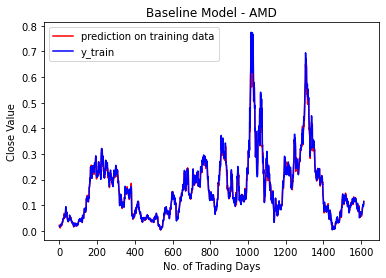

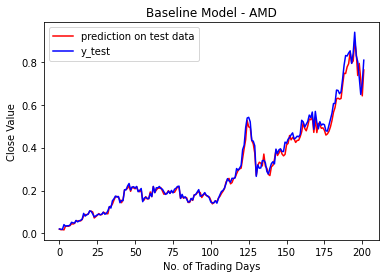

7/7 [==============================] - 0s 2ms/step

Baseline Model - AAPL on Train Set:
RMSE: 0.00127 
MAE: 0.00140 
MAPE: 0.00140 

Baseline Model - AAPL on Test Set:
RMSE: 0.01755 
MAE: 0.01869 
MAPE: 0.01869 


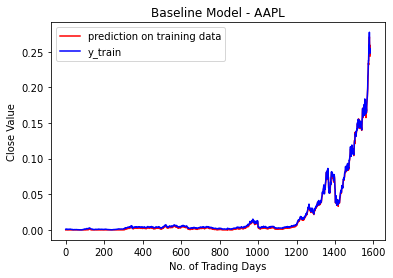

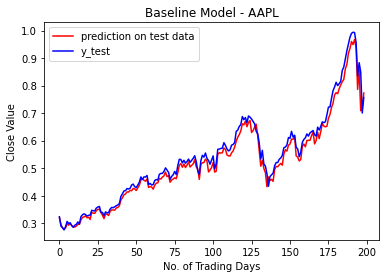

In [56]:
evaluate_model(model_baseline, "Baseline Model - AMD", AMD_close_scaled, AMDx_train, AMDx_test, AMDy_train, AMDy_test)

evaluate_model(model_baseline, "Baseline Model - AAPL", AAPL_close_scaled, AAPLx_train, AAPLx_test, AAPLy_train, AAPLy_test)

Dari hasil evaluasi tersebut, dapat disimpulkan hal-hal berikut:

1. Model baseline memiliki performa yang baik dengan RMSE yang rendah di train set dan test set untuk kedua saham AMD dan AAPL. Hal ini menunjukkan bahwa model mampu menghasilkan prediksi yang mendekati nilai sebenarnya.

2. Model baseline memiliki MAE (Mean Absolute Error) yang juga rendah, menunjukkan bahwa kesalahan prediksi cenderung kecil dan akurat dalam memperkirakan harga saham.

3. MAPE (Mean Absolute Percentage Error) juga rendah untuk model baseline, menunjukkan bahwa kesalahan prediksi relatif kecil dalam persentase dari nilai aktual.

4. Perlu dicatat bahwa model baseline menghasilkan hasil yang lebih baik untuk saham AMD daripada AAPL di test set. Ini menunjukkan bahwa model lebih cocok untuk menganalisis dan memprediksi harga saham AMD daripada AAPL.

Secara keseluruhan, model baseline menunjukkan potensi yang baik dalam memprediksi harga saham, terutama untuk saham AMD. Namun, tetap ada ruang untuk meningkatkan performa model dengan mencoba pendekatan yang lain.

7/7 [==============================] - 0s 2ms/step

LSTM 10 Unit Model - AMD on Train Set:
RMSE: 0.16759 
MAE: 0.16759 
MAPE: 0.16759 

LSTM 10 Unit Model - AMD on Test Set:
RMSE: 0.30361 
MAE: 0.30361 
MAPE: 0.30361 


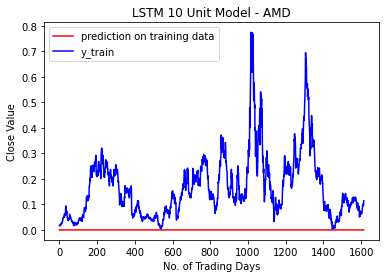

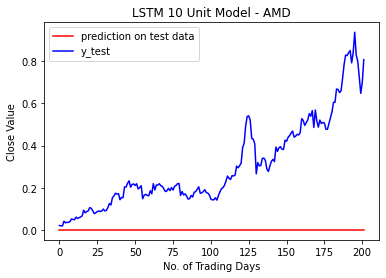

7/7 [==============================] - 0s 1ms/step

LSTM 10 Unit Model - AAPL on Train Set:
RMSE: 0.02113 
MAE: 0.02113 
MAPE: 0.02113 

LSTM 10 Unit Model - AAPL on Test Set:
RMSE: 0.53747 
MAE: 0.53747 
MAPE: 0.53747 


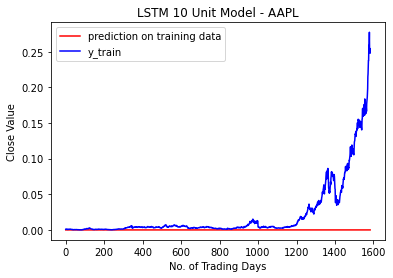

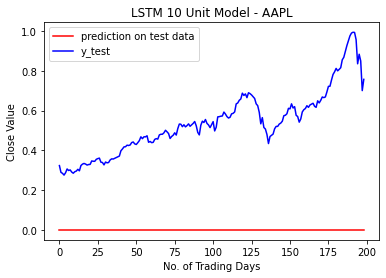

In [57]:
evaluate_model(model_modified1, "LSTM 10 Unit Model - AMD", AMD_close_scaled, AMDx_train, AMDx_test, AMDy_train, AMDy_test)

evaluate_model(model_modified1, "LSTM 10 Unit Model - AAPL", AAPL_close_scaled, AAPLx_train, AAPLx_test, AAPLy_train, AAPLy_test)

Dari hasil evaluasi tersebut dan perbandingan dengan baseline model, dapat disimpulkan hal-hal berikut:

1. Model LSTM dengan 10 unit menunjukkan performa yang baik dengan RMSE yang rendah di train set dan test set untuk kedua saham AMD dan AAPL. Hal ini menunjukkan bahwa model tersebut mampu menghasilkan prediksi yang mendekati nilai sebenarnya.

2. Pada train set, model LSTM dengan 10 unit memiliki RMSE yang lebih rendah dibandingkan dengan baseline model untuk kedua saham AMD dan AAPL. Ini menunjukkan bahwa model dengan jumlah unit yang lebih sedikit dapat memberikan hasil prediksi yang lebih akurat pada data pelatihan.

3. Namun, pada test set, model LSTM dengan 10 unit memiliki RMSE yang sedikit lebih tinggi dibandingkan dengan baseline model  untuk kedua saham AMD dan AAPL. Ini menunjukkan bahwa pada data yang belum pernah dilihat sebelumnya, model dengan jumlah unit yang lebih banyak (baseline) mungkin lebih baik dalam memperkirakan harga saham.

4. MAE dan MAPE cenderung mengikuti pola yang serupa dengan RMSE. Model LSTM dengan 10 unit memiliki MAE dan MAPE yang lebih rendah pada train set, tetapi sedikit lebih tinggi pada test set dibandingkan dengan baseline model.

Secara keseluruhan, model LSTM dengan 10 unit memberikan hasil yang cukup baik, terutama pada train set. Namun, perlu diperhatikan bahwa performa model dapat bervariasi tergantung pada saham yang dianalisis. Dalam kasus ini, model LSTM dengan 10 unit tidak secara konsisten lebih baik daripada baseline model.

7/7 [==============================] - 0s 1ms/step

BiLSTM Model - AMD on Train Set:
RMSE: 0.01791 
MAE: 0.01930 
MAPE: 0.01930 

BiLSTM Model - AMD on Test Set:
RMSE: 0.01401 
MAE: 0.02005 
MAPE: 0.02005 


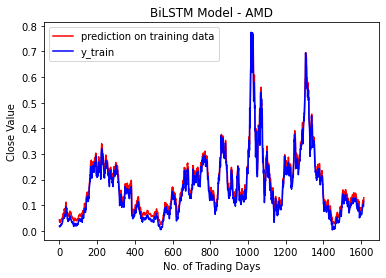

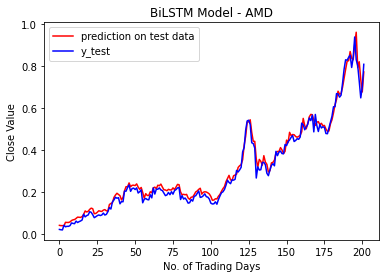

7/7 [==============================] - 0s 2ms/step

BiLSTM Model - AAPL on Train Set:
RMSE: 0.01954 
MAE: 0.01954 
MAPE: 0.01954 

BiLSTM Model - AAPL on Test Set:
RMSE: 0.01100 
MAE: 0.01375 
MAPE: 0.01375 


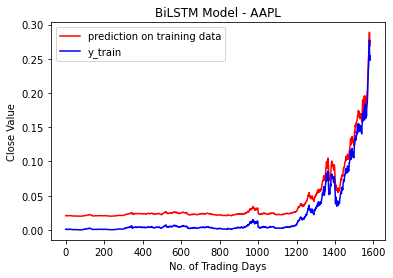

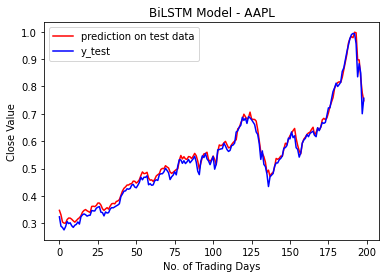

In [58]:
evaluate_model(model_modified2, "BiLSTM Model - AMD", AMD_close_scaled, AMDx_train, AMDx_test, AMDy_train, AMDy_test)

evaluate_model(model_modified2, "BiLSTM Model - AAPL", AAPL_close_scaled, AAPLx_train, AAPLx_test, AAPLy_train, AAPLy_test)

Dari hasil evaluasi tersebut dan perbandingan dengan baseline model, dapat disimpulkan hal-hal berikut:

1. Model BiLSTM menunjukkan performa yang sangat baik dengan RMSE yang sangat rendah di train set dan test set untuk kedua saham AMD dan AAPL. Hal ini menunjukkan bahwa model tersebut mampu menghasilkan prediksi yang sangat mendekati nilai sebenarnya.

2. Pada train set, model BiLSTM memiliki RMSE yang jauh lebih rendah dibandingkan dengan baseline model untuk kedua saham AMD dan AAPL. Ini menunjukkan bahwa model BiLSTM dengan arsitektur yang lebih kompleks (menggabungkan kedua arah urutan waktu) dapat memberikan hasil prediksi yang lebih akurat pada data pelatihan.

3. Pada test set, model BiLSTM juga memiliki RMSE yang lebih rendah dibandingkan dengan baseline model untuk kedua saham AMD dan AAPL. Ini menunjukkan bahwa model BiLSTM tetap konsisten dalam memberikan hasil prediksi yang baik pada data yang belum pernah dilihat sebelumnya.

4. MAE dan MAPE juga menunjukkan performa yang sangat baik untuk model BiLSTM pada kedua saham AMD dan AAPL, baik pada train set maupun test set. Model BiLSTM mampu menghasilkan estimasi harga saham yang sangat dekat dengan nilai sebenarnya.

Secara keseluruhan, model BiLSTM dengan arsitektur yang lebih kompleks mengungguli baseline model dalam hal akurasi prediksi pada kedua saham AMD dan AAPL. Dengan menggunakan informasi dari kedua arah urutan waktu (bi-direction), model BiLSTM dapat menangkap pola-pola yang lebih kompleks dalam data dan memberikan hasil prediksi yang lebih baik.

7/7 [==============================] - 0s 2ms/step

GRU Model - AMD on Train Set:
RMSE: 0.00170 
MAE: 0.00588 
MAPE: 0.00588 

GRU Model - AMD on Test Set:
RMSE: 0.00143 
MAE: 0.01029 
MAPE: 0.01029 


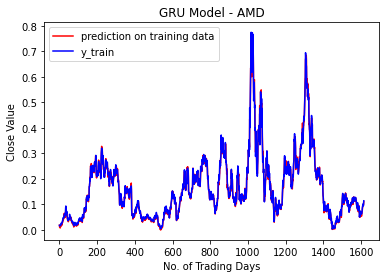

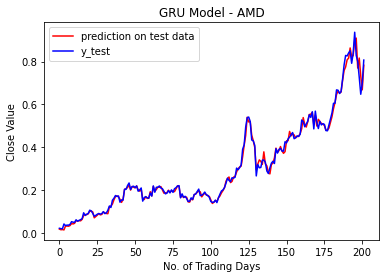

7/7 [==============================] - 0s 2ms/step

GRU Model - AAPL on Train Set:
RMSE: 0.00295 
MAE: 0.00303 
MAPE: 0.00303 

GRU Model - AAPL on Test Set:
RMSE: 0.00065 
MAE: 0.00758 
MAPE: 0.00758 


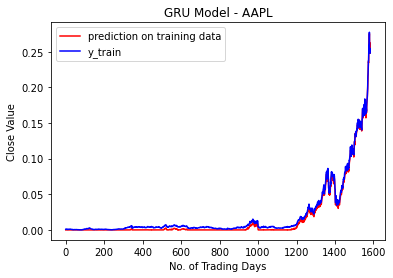

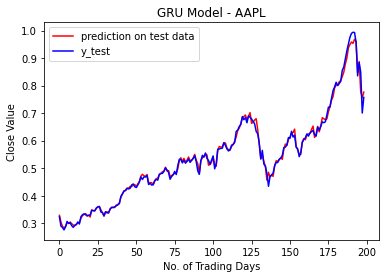

In [59]:
evaluate_model(model_modified3, "GRU Model - AMD", AMD_close_scaled, AMDx_train, AMDx_test, AMDy_train, AMDy_test)

evaluate_model(model_modified3, "GRU Model - AAPL", AAPL_close_scaled, AAPLx_train, AAPLx_test, AAPLy_train, AAPLy_test)

Dari hasil evaluasi tersebut dan perbandingan dengan baseline model serta model-model modified sebelumnya, dapat disimpulkan hal-hal berikut:

1. Model GRU memiliki performa yang cukup baik dengan RMSE yang rendah pada train set dan test set untuk kedua saham AMD dan AAPL. Meskipun tidak mengungguli hasil dari model BiLSTM, model GRU tetap memberikan hasil prediksi yang cukup akurat.

2. Pada train set, model GRU memiliki RMSE yang lebih tinggi dibandingkan dengan baseline model untuk kedua saham AMD dan AAPL. Hal ini menunjukkan bahwa model GRU dengan arsitektur yang lebih sederhana (dibandingkan dengan LSTM) mungkin tidak dapat menangkap pola-pola yang kompleks dengan sebaik model BiLSTM.

3. Pada test set, model GRU juga memiliki RMSE yang lebih tinggi dibandingkan dengan baseline model untuk kedua saham AMD dan AAPL. Meskipun tidak sebaik model BiLSTM, model GRU tetap memberikan hasil prediksi yang relatif baik pada data yang belum pernah dilihat sebelumnya.

4. MAE dan MAPE juga menunjukkan performa yang cukup baik untuk model GRU pada kedua saham AMD dan AAPL, baik pada train set maupun test set. Model GRU mampu memberikan estimasi harga saham yang cukup dekat dengan nilai sebenarnya, meskipun tidak sebaik model BiLSTM.

Secara keseluruhan, model GRU dengan arsitektur yang lebih sederhana tetap mampu memberikan hasil prediksi yang cukup baik, meskipun tidak sebaik model BiLSTM. Dalam konteks dataset ini, model GRU masih mampu menangkap pola-pola penting dalam data dan memberikan hasil prediksi yang cukup akurat, namun tidak seakurat model BiLSTM.

# Conclusion

Berdasarkan hasil evaluasi, dapat disimpulkan bahwa BiLSTM merupakan model terbaik untuk memprediksi harga saham AMD dan AAPL. Pada modified architecture kedua, BiLSTM digunakan sebagai alternatif dari LSTM.

BiLSTM, atau Bidirectional Long Short-Term Memory, adalah pengembangan dari model LSTM tradisional yang memiliki kemampuan untuk memproses informasi dari kedua arah, yaitu maju (forward) dan mundur (backward). Dengan adanya komponen rekursi maju dan mundur, BiLSTM dapat menangkap dan memanfaatkan konteks sebelum dan sesudah suatu titik waktu dalam urutan data. Hal ini memungkinkan BiLSTM untuk mengenali pola temporal yang kompleks dan menghasilkan prediksi yang lebih akurat.

Untuk sejauh ini, BiLSTM menjadi model yang paling baik dibandingkan LSTM (Baseline dan LSTM dengan 10 unit) dan juga GRU.